In [1]:
import os
import cv2
import numpy as np
import glob
from PIL import Image, ImageEnhance
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from utils import *
from copy import deepcopy
plt.rcParams['figure.figsize'] = [18, 9]
plt.rcParams['font.size'] = 16
from skimage.io import imread
from skimage import data, io, img_as_float, exposure
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import nd2
import tifffile

---

# Define global variables

In [2]:
PATH = "18-08-2022 ING glu4 irap syntaxin4"
CONTRAST = 13
BRIGHTNESS = 0.2
SENSITIVITY = 130

---

# Process images

In [4]:
files_names = os.listdir(PATH)  

for num, file_name in enumerate(files_names):
    if ".ipynb" in file_name:
        print("continue...")
        continue
    file_name = os.path.join(PATH, file_name)
    #im = imread(os.path.join(PATH, file_name), plugin="tifffile")
    try:
        im = nd2.imread(file_name)
    except:
        print(f"file {file_name} cannot be read")
        continue
    im = np.rollaxis(im, 0,3)

    size = im.shape[1]
    n_channels = im.shape[2]

    channel_images = process_channels(im, file_name, clip_limit=0.03, 
                                      contrast=CONTRAST, brightness=BRIGHTNESS)

    # Mask extraction

    sensitivities = [SENSITIVITY for i in range(n_channels)]

    channel_names = [f"Channel {i+1}" for i in range(n_channels)]

    detections = {}
    for i in channel_names:
            detections[i] = 0

    fig = make_subplots(rows=1,cols=n_channels, shared_xaxes="all", 
                        shared_yaxes="all",
                        subplot_titles = (channel_names))


    df_RGB = pd.DataFrame(columns = ["File", "Channel", "#", "Intensity", "AreaPx", "Areamic", "Protein", "Type"])

    for j, image in enumerate(channel_images):
        colors = ["#00FF00", "#FF00FF", "#00BFFF"]

        ch_image = px.imshow(image,
                             color_continuous_scale='gray',
                             binary_string=True, binary_backend="jpg")

        fig = fig.add_trace(ch_image.data[0],
                           row=1, col=j+1)

        fig.update_layout(coloraxis_showscale=False)
        fig.update_xaxes(showticklabels=False)
        fig.update_yaxes(showticklabels=False)

        mask, contours, hierarchy = extract_masks(image, sensitivities[j], dilation=False)
        detections[channel_names[j]] = len(contours)

        for i in range(len(contours)):

            contour_im = cv2.drawContours(deepcopy(mask) , contours, i, (255,0,0),-1, hierarchy=hierarchy, maxLevel = 0)

            contour_idx = np.where(contour_im.flatten()<250)
            noncontour_idx = np.where(contour_im.flatten()>250)

            cropped_mask = deepcopy(image.reshape(-1))
            cropped_mask[contour_idx] = 0 

            intensity = int(np.round(np.median(cropped_mask[noncontour_idx])))
            area_px = len(cropped_mask[noncontour_idx])
            if area_px>300:
                continue
            area_si = np.round(area_px*(0.12**2), decimals=4)
            
            protein_list = sorted(file_name.replace("-","_").split("/")[-1].split("_")[1:-1])
            proteins = ""
            for protein in protein_list:
                proteins += "+"+protein

            new_entry = pd.DataFrame(
                {"File" : pd.Series(file_name, dtype="string"),
                 "Channel" : pd.Series(j, dtype="int"),
                "#": pd.Series(i, dtype="int"),
                "Intensity": pd.Series(intensity, dtype="int"),
                "AreaPx": pd.Series(area_px, dtype="int"),
                "Areamic": pd.Series(area_si, dtype="float"),
                "Type": pd.Series(file_name.replace("-","_").split("/")[-1].split("_")[0], dtype="string"),
                "Protein": pd.Series(proteins, dtype="string")})

            df_RGB = pd.concat([df_RGB, new_entry], ignore_index=True)

            cropped_mask = cropped_mask.reshape(size,size)

            x_con = contours[i].reshape(contours[i].shape[0],-1)[:,0]
            y_con = contours[i].reshape(contours[i].shape[0],-1)[:,1]
            hoverinfo = f"Intensity: {intensity}/255<br>Area: {area_px} px | {area_si} μm²"
            fig.add_scatter(x=x_con, y=y_con, 
                            mode="lines",
                            fill="toself",
                            line=dict(color=colors[j]),
                            showlegend=False,
                            hovertemplate=hoverinfo,
                            hoveron="points+fills",
                            name=f"#{i+1}",
                            row=1, col=j+1
                           )
        fig.layout.annotations[j].update(y=0.9)
    fig.for_each_annotation(lambda a: a.update(text = a.text + "    #Detections: "+str(detections[a.text])))
    fig['layout'].update(height=image.shape[1]*0.8, 
                         width=image.shape[1]*1.7)

    #fig.show()


    if not os.path.exists(os.path.join("results", file_name)):
        os.mkdir(os.path.join("results", file_name))


    df_RGB.to_csv(f"results/{file_name}/info.csv")
    fig.write_html(f"results/{file_name}/detections.html")
    
    print(f"{num+1}/{len(files_names)} ... finished processing file {file_name}")

1/45 ... finished processing file 18-08-2022 ING glu4 irap syntaxin4/basal_glut4_irap_syntaxin4_018.nd2
2/45 ... finished processing file 18-08-2022 ING glu4 irap syntaxin4/ins_glut4_irap_syntaxin4_003.nd2
3/45 ... finished processing file 18-08-2022 ING glu4 irap syntaxin4/basal_glut4_irap_syntaxin4_001.nd2
4/45 ... finished processing file 18-08-2022 ING glu4 irap syntaxin4/ins_glut4_irap_syntaxin4_002.nd2
5/45 ... finished processing file 18-08-2022 ING glu4 irap syntaxin4/ins_glut4_irap_syntaxin4_008.nd2
6/45 ... finished processing file 18-08-2022 ING glu4 irap syntaxin4/basal_glut4_irap_syntaxin4_020.nd2
7/45 ... finished processing file 18-08-2022 ING glu4 irap syntaxin4/ins_glut4_irap_syntaxin4_010.nd2
8/45 ... finished processing file 18-08-2022 ING glu4 irap syntaxin4/basal_glut4_irap_syntaxin4_017.nd2
9/45 ... finished processing file 18-08-2022 ING glu4 irap syntaxin4/basal_glut4_irap_syntaxin4_011.nd2
10/45 ... finished processing file 18-08-2022 ING glu4 irap syntaxin4/ba

-----

# Compute statistics

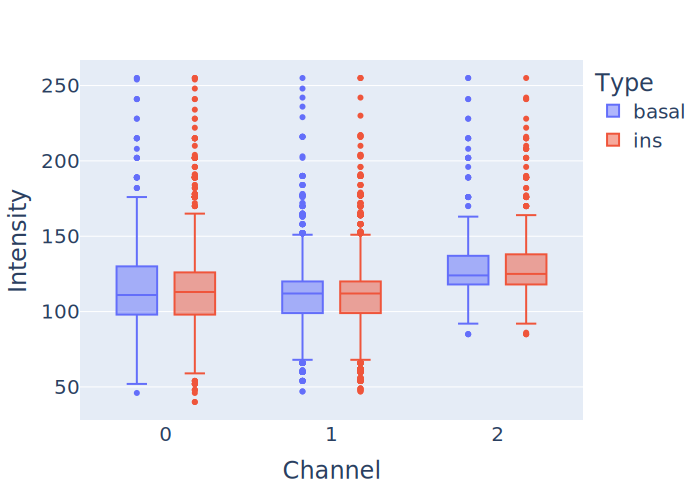

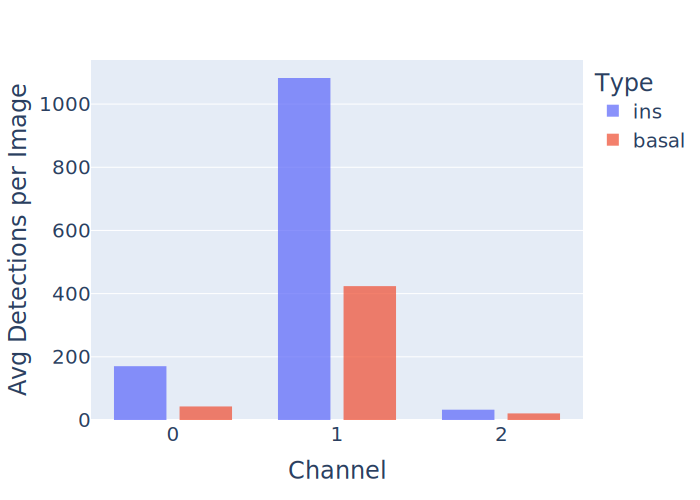

In [5]:
import glob
import plotly.graph_objects as go
import plotly.express as px
pio.renderers.default='svg'
                         

images_list = glob.glob(f"results/{PATH}/*/*.csv")
# If you want to show results for all kind of proteins inside PATH folder, set protein = None
compute_statistics(images_list, protein = "glut4+irap+syntaxin4", tag = PATH)